# 1、前言
LangGraph 具有内置的持久化层，通过检查点器实现。当使用检查点器编译图时，检查点器会在每个`super-step`中保存图的状态的 checkpoint 。这些检查点会保存到 `thread` 中，在图执行后可以访问。由于 threads 允许在执行后访问图的状态，因此包括人工介入、记忆、时间旅行和容错性在内的多种强大功能都成为可能。下面，我们将更详细地讨论这些概念。

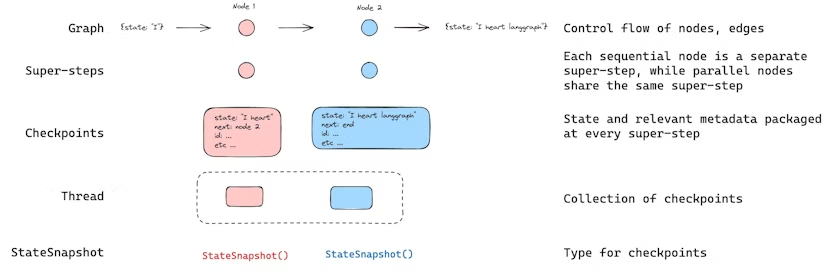

# 模型初始化

In [14]:
from langchain_openai import ChatOpenAI
import os, dotenv

dotenv.load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_BASE_URL"] = os.getenv("OPENAI_BASE_URL")

llm = ChatOpenAI(model="gpt-5-mini")

# 2、线程（Thread）
线程是检查点器给每一个的 `checkpoint` 的分配的唯一线程 ID 或者或是标识符。它包含了一系列 graph 运行过程中累积的状态。当 graph 在运行时，底层会自动地将状态持久化到线程中。

在使用带 checkpoint 的图进行编译时，必须在 config 里的 `configurable` 键指定线程 id，比如下面这样：

> ```python
> {"configurable": {"thread_id": "123"}}
> ```

`thread_id`对于检查点是至关重要的，没有线程 id，检查点无法保存和访问图的状态。

# 3、检查点（Checkpoint）
检查点是图在运行过程中保存的状态快照。每当图完成一个 `super-step`，检查点器都会创建一个新的检查点，并将当前图的状态保存到与该检查点关联的线程中。
由具有以下属性的 `StateSnapshot` 对象表示：

* config：与当前检查点相关联的配置
* metadata：与当前检查点相关联的元数据
* values：此时状态通道的值
* next：元组，表示下一个要执行的节点
* tasks：元组，包含下一个要执行任务的信息，如果改步骤之前已经被执行过，那么还会包含失败的信息；如果图在节点内部被动态中断，任务还会包含和中断相关的额外数据。

下面看一个简单示例，在图的运行过程中都创建了那些检查点：

In [24]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from typing import Annotated
from langchain_core.runnables import RunnableConfig
from typing_extensions import TypedDict
import operator


# 定义图的状态
class State(TypedDict):
    foo: str
    bar: Annotated[list[str], operator.add]


# 定义节点
def node_a(state: State):
    print("节点a 开始执行...")
    return {"foo": "a", "bar": ["a"]}


def node_b(state: State):
    print("节点 b 开始执行...")
    return {"foo": "b", "bar": ["b"]}


# 定义工作流
workflow = StateGraph(State)
# 添加节点
workflow.add_node("node_a", node_a)
workflow.add_node("node_b", node_b)
# 添加边
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

# 添加检查点器
checkpointer = InMemorySaver()
# 编译图
graph = workflow.compile(checkpointer=checkpointer)
# 配置线程
config: RunnableConfig = {"configurable": {"thread_id": "thread_1"}}
# 调用
graph.invoke(input={"foo": "", "bar": []}, config=config)

节点a 开始执行...
节点 b 开始执行...


{'foo': 'b', 'bar': ['a', 'b']}

## 3.1、获取状态
在与保存的图状态交互时，你必须指定一个线程标识符。你可以通过调用 graph.get_state(config) 来查看图的最新状态。这将返回一个 `StateSnapshot` 对象，该对象对应于配置中提供的线程 ID 关联的最新检查点，或者如果提供了检查点 ID，则对应于线程的检查点 ID 关联的检查点。

In [12]:
import json

# 获取最新快照的图状态
config = {"configurable": {"thread_id": "thread_1"}}
state = graph.get_state(config=config)
json.dumps(state)

# 获取指定检查点 id 关联的图状态快照
config = {"configurable": {"thread_id": "thread_1", "checkpoint_id": "1f0e18ec-f228-6134-8001-51ed47b662fc"}}
graph.get_state(config=config)
# json.dumps(state)

StateSnapshot(values={'foo': 'a', 'bar': ['a']}, next=('node_b',), config={'configurable': {'thread_id': 'thread_1', 'checkpoint_id': '1f0e18ec-f228-6134-8001-51ed47b662fc'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-12-25T12:39:52.523586+00:00', parent_config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0e18ec-f225-6916-8000-9eceb872a63c'}}, tasks=(PregelTask(id='25b3e384-864c-9655-da16-ad01869588d2', name='node_b', path=('__pregel_pull', 'node_b'), error=None, interrupts=(), state=None, result={'foo': 'b', 'bar': ['b']}),), interrupts=())

## 3.2、获取图的历史状态
你可以通过调用 graph.get_state_history(config) 来获取给定线程的图执行完整历史记录。这将返回一个与配置中提供的线程 ID 相关联的 StateSnapshot 对象列表。重要的是，检查点将按时间顺序排列，最新的检查点/ StateSnapshot 将位于列表的第一位。

In [13]:
# 获取图的历史状态
config:RunnableConfig = {"configurable": {"thread_id": "thread_1"}}
list(graph.get_state_history(config))

[StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0e18ec-f229-6fe8-8002-851e4aaaac4d'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-12-25T12:39:52.524381+00:00', parent_config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0e18ec-f228-6134-8001-51ed47b662fc'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'foo': 'a', 'bar': ['a']}, next=('node_b',), config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0e18ec-f228-6134-8001-51ed47b662fc'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-12-25T12:39:52.523586+00:00', parent_config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0e18ec-f225-6916-8000-9eceb872a63c'}}, tasks=(PregelTask(id='25b3e384-864c-9655-da16-ad01869588d2', name='node_b', path=('__pregel_pull', 'node

## 3.3、Reply 功能（从检查点回溯）
Reply 功能允许从之前的检查点继续执行图，这对于实现人工介入、修复错误或探索不同的执行路径非常有用。

给定config（包含线程 id 和 checkpoint_id），通过 `graph.invoke(config)`，graph 将从 checkpoint_id 之后的节点开始重新执行一遍。

注意：重新执行的节点不包含 checkpoint_id 对应的节点本身。

In [ ]:
# 演示 langgraph 的 reply 功能 - 从检查点回溯

# 首先，查看执行历史中的所有检查点
print("=" * 60)
print("获取图的完整执行历史")
print("=" * 60)

config = {"configurable": {"thread_id": "thread_1"}}
history = list(graph.get_state_history(config))

print(f"\n总共有 {len(history)} 个检查点\n")
for i, snapshot in enumerate(history):
    print(f"检查点 {i}:")
    print(f"  - Next nodes: {snapshot.next}")
    print(f"  - State values: {snapsh¶ot.values}")
    print(f"  - Checkpoint ID: {snapshot.config.get('configurable', {}).get('checkpoint_id')}")
    print()

获取图的完整执行历史

总共有 4 个检查点

检查点 0:
  - Next nodes: ()
  - State values: {'foo': 'b', 'bar': ['a', 'b']}
  - Checkpoint ID: 1f0e1972-29bf-6fea-8002-33e43547088e

检查点 1:
  - Next nodes: ('node_b',)
  - State values: {'foo': 'a', 'bar': ['a']}
  - Checkpoint ID: 1f0e1972-29be-678a-8001-a871d4270160

检查点 2:
  - Next nodes: ('node_a',)
  - State values: {'foo': '', 'bar': []}
  - Checkpoint ID: 1f0e1972-29b9-6cee-8000-24d96decc9f6

检查点 3:
  - Next nodes: ('__start__',)
  - State values: {'bar': []}
  - Checkpoint ID: 1f0e1972-29b6-6df0-bfff-c51b18b18639



In [ ]:
# 从倒数第二个检查点回溯执行
print("=" * 60)
print("从倒数第二个检查点开始重新执行")
print("=" * 60)

# 获取倒数第二个检查点的 ID
second_last_checkpoint = history[1]  
checkpoint_id = second_last_checkpoint.config['configurable']['checkpoint_id']

print(f"\n选择检查点 ID: {checkpoint_id}")
print(f"该检查点的状态: {second_last_checkpoint.values}")
print(f"该检查点要执行的下一步: {second_last_checkpoint.next}\n")

# 从这个检查点继续执行
config_with_checkpoint = {
    "configurable": {
        "thread_id": "thread_1",
        "checkpoint_id": checkpoint_id
    }
}

result = graph.invoke(input=None, config=config_with_checkpoint)
print(f"重新执行后的最终状态: {result}\n")

从倒数第二个检查点开始重新执行

选择检查点 ID: 1f0e1972-29be-678a-8001-a871d4270160
该检查点的状态: {'foo': 'a', 'bar': ['a']}
该检查点要执行的下一步: ('node_b',)

节点 b 开始执行...
重新执行后的最终状态: {'foo': 'b', 'bar': ['a', 'b']}



In [ ]:
# 演示修改状态后重新执行（人工介入场景）
print("=" * 60)
print("从检查点修改状态后重新执行（人工介入）")
print("=" * 60)

# 获取最早的检查点（第一个节点执行完后）
earliest_checkpoint = history[-1]
earliest_checkpoint_id = earliest_checkpoint.config['configurable']['checkpoint_id']

print(f"\n回到初始检查点 ID: {earliest_checkpoint_id}")
print(f"该检查点的状态: {earliest_checkpoint.values}\n")

# 从这个检查点继续，但传入修改后的输入
config_with_earliest = {
    "configurable": {
        "thread_id": "thread_1",
        "checkpoint_id": earliest_checkpoint_id
    }
}

# 使用修改后的状态继续执行
modified_input = {"foo": "modified", "bar": ["manual_intervention"]}
result_modified = graph.invoke(input=modified_input, config=config_with_earliest)
print(f"修改后重新执行的最终状态: {result_modified}\n")

# 查看修改后新生成的检查点历史
print("=" * 60)
print("修改后的完整历史（注意新增的检查点）")
print("=" * 60)

new_history = list(graph.get_state_history(config))
print(f"\n现在总共有 {len(new_history)} 个检查点\n")
for i, snapshot in enumerate(new_history[:5]):  # 只显示前5个
    print(f"检查点 {i}: {snapshot.values}")

## 3.4、更新状态
除了replay来自特定 checkpoints 的图，我们还可以编辑图状态。我们使用 `update_state` 来完成这个操作。这个方法接受三个不同的参数：
- config: config 包含了 thread_id 字段，指定要更新的线程。当仅传递了 thread_id 时，图的最新状态将被更新。如果还传递了 `checkpoint_id`，那么将更新指定检查点的图状态。
- values: values 是一个字典，包含要更新的状态通道及其新值。需要再多说一点的是，如果状态的字段没有指定 reducer 函数（比如 operator），那么这些字段将会被新值覆盖。
- as_node: as_node 是一个可选参数，指定是哪个节点来执行这次状态更新。如果没有指定，默认是最新执行的节点。

In [25]:
# 演示 as_node 参数的作用
print("=" * 60)
print("演示 as_node 参数的作用")
print("=" * 60)

# 获取当前状态
config = {"configurable": {"thread_id": "thread_1"}}
current_state = graph.get_state(config)
print(f"\n当前状态: {current_state.values}")
print(f"当前 next 节点: {current_state.next}\n")

# 方式1：以 node_a 的身份更新状态
print("【方式1】以 node_a 的身份更新状态：")
graph.update_state(
    config=config,
    values={"foo": "updated_by_node_a", "bar": ["manual_update_a"]},
    as_node="node_a"
)

updated_state_1 = graph.get_state(config)
print(f"更新后的状态: {updated_state_1.values}")
print(f"更新后 next 节点: {updated_state_1.next}")
print(f"记录此更新的节点: node_a\n")

# 方式2：以 node_b 的身份更新状态
print("【方式2】以 node_b 的身份更新状态：")
graph.update_state(
    config=config,
    values={"foo": "updated_by_node_b", "bar": ["manual_update_b"]},
    as_node="node_b"
)

updated_state_2 = graph.get_state(config)
print(f"更新后的状态: {updated_state_2.values}")
print(f"更新后 next 节点: {updated_state_2.next}")
print(f"记录此更新的节点: node_b\n")

# 查看历史记录
print("=" * 60)
print("查看更新后的历史检查点")
print("=" * 60)

history = list(graph.get_state_history(config))
print(f"\n总检查点数: {len(history)}\n")
for i, snapshot in enumerate(history[:5]):
    print(f"检查点 {i}: next={snapshot.next}, values={snapshot.values}")

演示 as_node 参数的作用

当前状态: {'foo': 'b', 'bar': ['a', 'b']}
当前 next 节点: ()

【方式1】以 node_a 的身份更新状态：
更新后的状态: {'foo': 'updated_by_node_a', 'bar': ['a', 'b', 'manual_update_a']}
更新后 next 节点: ('node_b',)
记录此更新的节点: node_a

【方式2】以 node_b 的身份更新状态：
更新后的状态: {'foo': 'updated_by_node_b', 'bar': ['a', 'b', 'manual_update_a', 'manual_update_b']}
更新后 next 节点: ()
记录此更新的节点: node_b

查看更新后的历史检查点

总检查点数: 6

检查点 0: next=(), values={'foo': 'updated_by_node_b', 'bar': ['a', 'b', 'manual_update_a', 'manual_update_b']}
检查点 1: next=('node_b',), values={'foo': 'updated_by_node_a', 'bar': ['a', 'b', 'manual_update_a']}
检查点 2: next=(), values={'foo': 'b', 'bar': ['a', 'b']}
检查点 3: next=('node_b',), values={'foo': 'a', 'bar': ['a']}
检查点 4: next=('node_a',), values={'foo': '', 'bar': []}
